In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

# Packages

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import arviz
import pystan
import time

In [4]:
my_data = pd.read_csv('../../../../Catalogue/binom_reg_dataset.csv')

In [5]:
# filtering the dataset
redshifts   = my_data['Z']
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values.astype(int)    # y axis: logit class: UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values.astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values.astype(int)                    # 1st parameter
redshift    = redshifts.values.astype(float)                                # 2nd parameter

In [6]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [7]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                       # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

In [8]:
# Fit: STAN code -----------------------------------------------------------------------------------------------------
stan_code = """
// DECLARATION OF VARIABLES ------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) ---------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;       // 25 betas!
    real<lower=0> sigma;    // Shared hyperpriors
    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION -----------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
    mu ~ normal(0, 100);                                   // shared hyperpriors
     
    for (i in 1:K) {
       for (j in 1:C) beta[i,j] ~ normal(mu, sigma);       // priors
        }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED ------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        prob02[j] = inv_logit(eta02[j]);
        prob03[j] = inv_logit(eta03[j]);
        prob04[j] = inv_logit(eta04[j]);
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

In [9]:
iterations = 2500
chains     = 3                           # HMC chains
warmup     = 500                       # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # Run code in parallel -- see pystan documentation
seed       = 1

In [10]:
control = {}
control['max_treedepth'] = 20
control['adapt_delta'] = 0.99

In [11]:
start = time.time()

fit = pystan.stan(model_code=stan_code, data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup,
                  n_jobs=jobs, control=control)

end = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50fd202ecaf8992b685aa66bc38cb07a NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 3.15 [min]
--------------------------------------------------


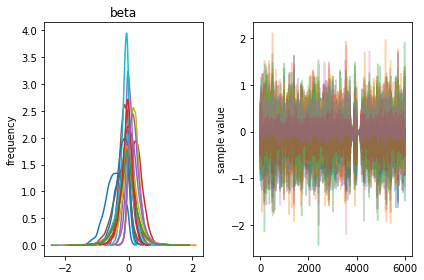

In [13]:
fit.plot('beta')
plt.tight_layout()
plt.show()